## Viterbi Alignment

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  23/03/23
+ ###### Requires: pyspch v0.7   

Content:
- Evaluate the sequence effect of the HMM model


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM

In [236]:
#@title Auxiliary functions

def plot_probs(probs, labels,  fig, iax=2, x0=0.,vmin=None, title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,vmin=vmin,linewidths=1,linecolor='k',cbar_kws={'pad':0.0})
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.],color=None)
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

# Helper routines for loading test samples
def get_test_file(file_id, feature_args=None,
                          root='https://homes.esat.kuleuven.be/~spchlab/data/',type=None):
    '''
    extracts waveform and metadata for a named file
    
    PARAMETERS:
    -----------
    file_id         either number (0..5) or a filename in the TIMIT directory
    feature_args    signal processing specifications
    root            root directory (default is ./data/  on spchlab public html)
    
    RETURNS:
    --------
    wavdata  wav data
    sr     sample_rate
    spg    spectrogram
    ftrs   feature extraction according to feature_args
    txt    utterance transcription
    wrd    wrd segmentation
    phn    phn segmentation
    '''
    timit_test_files =  ['dr1/faks0/si2203',  'dr8/fcmh1/si1493', 'dr4/fadg0/si1279', 
                         'dr1/mdab0/sx409','dr4/mbns0/si1220']
                        #, dr1/fcjf0/sx307', 'dr1/fdaw0/sx236', 'dr1/faks0/sx313'] 
    if file_id in [0,1,2,3,4]:
        name = "test/"+timit_test_files[file_id]
    else:
        name = file_id
        
    if type == "TIMIT":
        dt = 1/16000
        xlat = 'timit61_timit41'
        audio_root = root+'timit/audio/'
        seg_root = root+'timit/segmentation/'
    else:
        dt = 1
        xlat = None
        audio_root = root
        seg_root = root
        
    # get audio
    if 'sample_rate' in feature_args.keys():
        sr = feature_args['sample_rate']
    else:
        sr = None
    wavdata, sr = pyspch.audio.load(audio_root + name + ".wav",sample_rate=sr)
    # get segmentations
    wrd = pyspch.timit.read_seg_file(seg_root + name + ".wrd",dt=dt)   
    phn = pyspch.timit.read_seg_file(seg_root + name + ".phn",dt=dt,xlat=xlat)
    if phn is None: # try grapheme if no phn is available
            phn = pyspch.timit.read_seg_file(seg_root + name + ".gra",dt=dt)
        
    spg = pyspch.sp.feature_extraction(wavdata, sample_rate=sr)
    ftrs = pyspch.sp.feature_extraction(wavdata, **feature_args)
    txt = ' '.join(wrd['seg'])
    
    return(wavdata,sr,spg,ftrs,txt,wrd,phn)

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

In [5]:
def make_viterbi_graph(phn_seq,phn_set,STRICT=True):
    ''' 
    makes an HMM Graph to do a Viterbi Alignment on phn_seq
    it is implemented with a transition matrix with 0's and 1's
    STRICT
        True:   Enforce Viterbi 100%
        False:  Allow skips and begin/end in 2 adjacent states
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')
    init_mat = np.zeros(n_seq,dtype='float32')
    
    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    for i in range(n_seq-1):
        trans_mat[i,i+1] = 1.
        init_mat[0] = 1.0        

    if STRICT:
        end_states = np.array([n_seq-1])
    else:
        end_states = np.array([n_seq-2,n_seq-1])
        init_mat[1] = 1.0
        for i in range(n_seq-2):
            trans_mat[i,i+2]=1.
            
    return(obs_indx,trans_mat,init_mat,end_states)

## 1. Setting Up

### Feature Extraction
MFCC26=  MFCC13 + Deltas + mean-variance normalization, (defined by feature_args).

### GMM models
Available models are (training in timit-3.ipynb notebook):      
- **S41_D26_G8_MINI_1.pkl**         (FrameRecog: 50%)    S41= 41 classes/states, D26 = 26 dim features, G8 = 8 Gaussians, FULL_1 = training database + version number
- **S41_D26_G64_FULL_1.pkl**        (FrameRecog: 56%)

##### note on pickle (6/3/2024)
the models were pickled with sklearn 1.0.2 and read well with sklearn 1.4.0, so the version inconsistency warning can be disregarded at least up to that version

In [248]:
# task setup
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# define feature extraction: MFCC13 + delta's + mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
#clf_GMM = Spch.load_data("S41_D26_G8_MINI_1.pkl",root=gmm_root)  # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_GMM = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
phn_set= clf_GMM.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Run Example File

The following cells take care of
1. loading test sample and segmentations
2. spg and feature computation
3. set some focus time to highlight one or a couple of words in a full sentence

The first cell will load our prototypical "friendly computers"; the second cell loads one of a few preselected TIMIT test files.
Just execute one of these cells

In [191]:
# loading a test file (non-TIMIT)
file_id =  'misc/friendly'
focus_times = np.array([0.5,1.01])
type = None

In [243]:
# loading a TIMIT test file
# choose an example from 0 .. 4 
file_id = 4
timit_focus_times = [ [2.10,3.07], [.12,.88], [.05,.51], [0.,.85], [2.05,2.62]]
focus_times = np.array(timit_focus_times[file_id])
type = "TIMIT"

In [244]:
# load all the data
wavdata, sr, spgdata, ftrs, txt, seg_wrd, seg_phn = get_test_file(file_id,feature_args=feature_args,type=type)
print(txt,seg_wrd)

# select a time segment to focus on and find corresponding phones / transcription
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
shift=feature_args['f_shift']
frames= (focus_times/shift).astype('int')
samples = (focus_times*sr).astype('int')
sample_sel = slice(samples[0],samples[1])
frame_sel = slice(frames[0],frames[1])
seg_sel = seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]
state_sel = np.array(seg_sel.index.tolist())
label_sel = labels[frame_sel]

they also want money prestige and security     t0   t1       seg
0 0.12 0.29      they
1 0.29 0.69      also
2 0.69 0.95      want
3 0.95 1.26     money
4 1.26 1.91  prestige
5 1.91 2.06       and
6 2.06 2.62  security


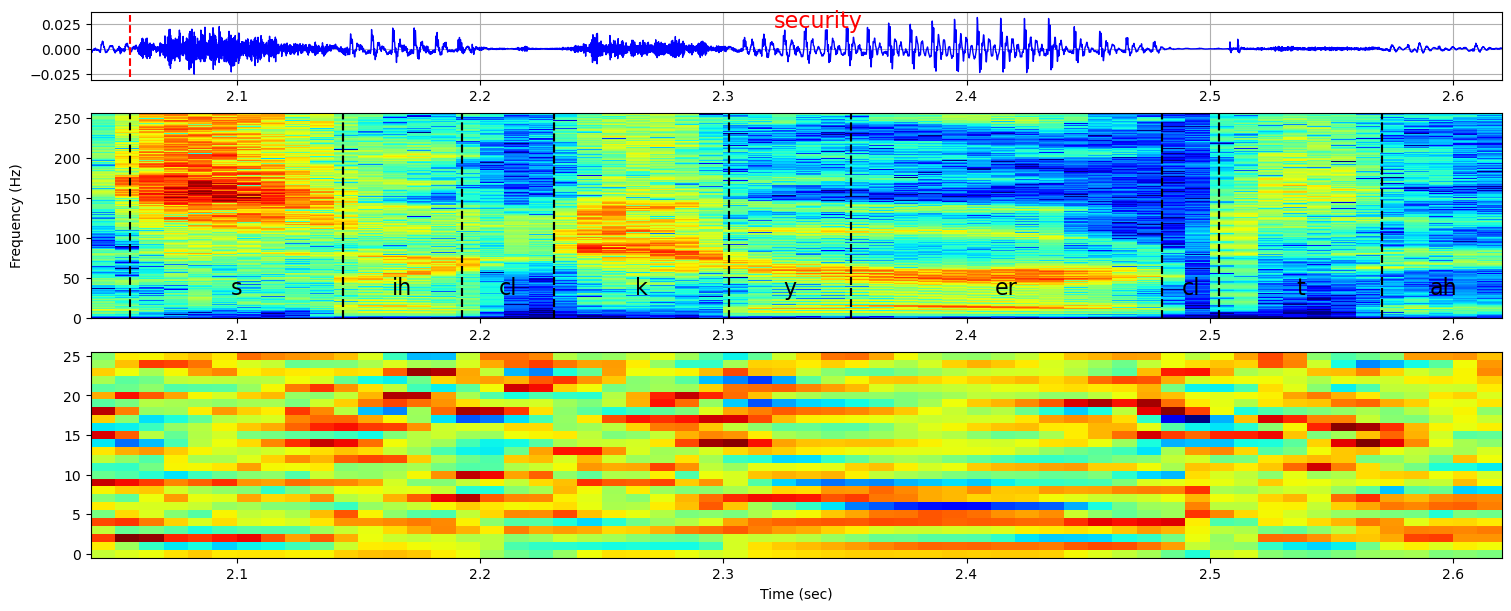

In [245]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
##############################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,
                                 frames=frames, sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=wavdata[sample_sel],rate=sr))

### FRAME Recognition

In [249]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# compute posterior probs in the model
X = ftrs.T
y_gmm_prob = clf_GMM.predict_proba(X) # ,priors=[1]*41)  #equalizing the priors will make it worse
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(y_gmm_prob, axis=1)
y_gmm_lab = [phn_set[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=features.T)
t = np.arange(len(y_gmm_lab))*shift+0.5*shift
y_gmm_ldf = pd.DataFrame({'t':t,'lbl':y_gmm_lab})
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))


Frame Recognition Rate (for full utterance): 65.84 %


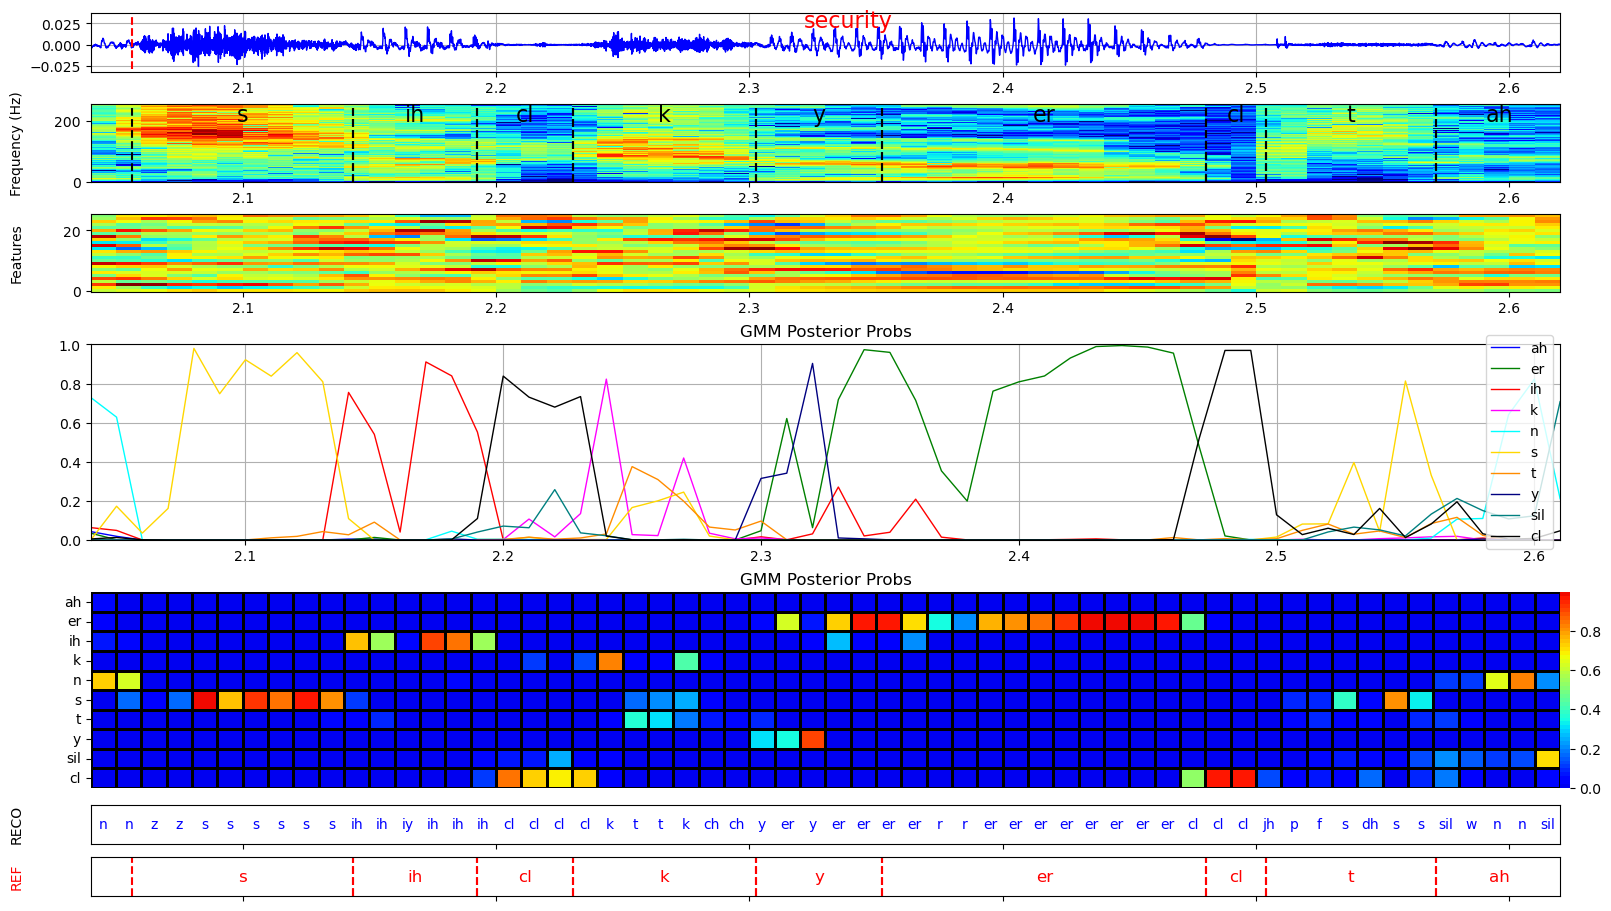

Frame Recognition Rate: 31/58 (53.45%)


In [250]:
# make a selection of phones to plot
# include the most likely outputs and the phones in the transcriptions
top_k = 5
indx_sel = np.argsort(np.sum(y_gmm_prob[frame_sel,:],axis=0))[::-1][0:top_k]
phn_sel = [phn_set[i] for i in indx_sel]
phn_sel, indx_sel = select_phones_idx((seg_sel['seg'],phn_sel,['sil']),phn_set,SORTED=True)

# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,2,5,5,1,1],
            frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[ftrs,None,None],img_labels=['Features',None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*shift, style="line", title="GMM Posterior Probs")
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=4, x0=frames[0]*shift, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_ldf,iax=5,ypos=.5,color='#00F',size=10)
fig.add_seg_plot(seg_phn,iax=6,ypos=.5,color='r',size=12)
fig.axes[5].set_ylabel('RECO')
fig.axes[6].set_ylabel('REF',color='r')
display(fig)
n_corr = np.sum([y_gmm_lab[i] == labels[i] for i in range(frames[0],frames[1])])
n_frames = (frames[1]-frames[0])
print("Frame Recognition Rate: %d/%d (%.2f%%)" % (n_corr,n_frames,100.*n_corr/n_frames))

### Viterbi Alignment

In [242]:
# viterbi Alignment
transcript = seg_phn['seg'].tolist()
#### optionally append silence
transcript = transcript + ['sil']
state_sel = np.append(state_sel,state_sel[-1]+1)
#

In [233]:
obs_indx, trans_mat,init_mat,end_states = make_viterbi_graph(transcript,phn_set,STRICT=False)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=clf_GMM,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# setting to log-probabilities gives a better impression of relevant ranges
hmm2.set_probstyle('log')

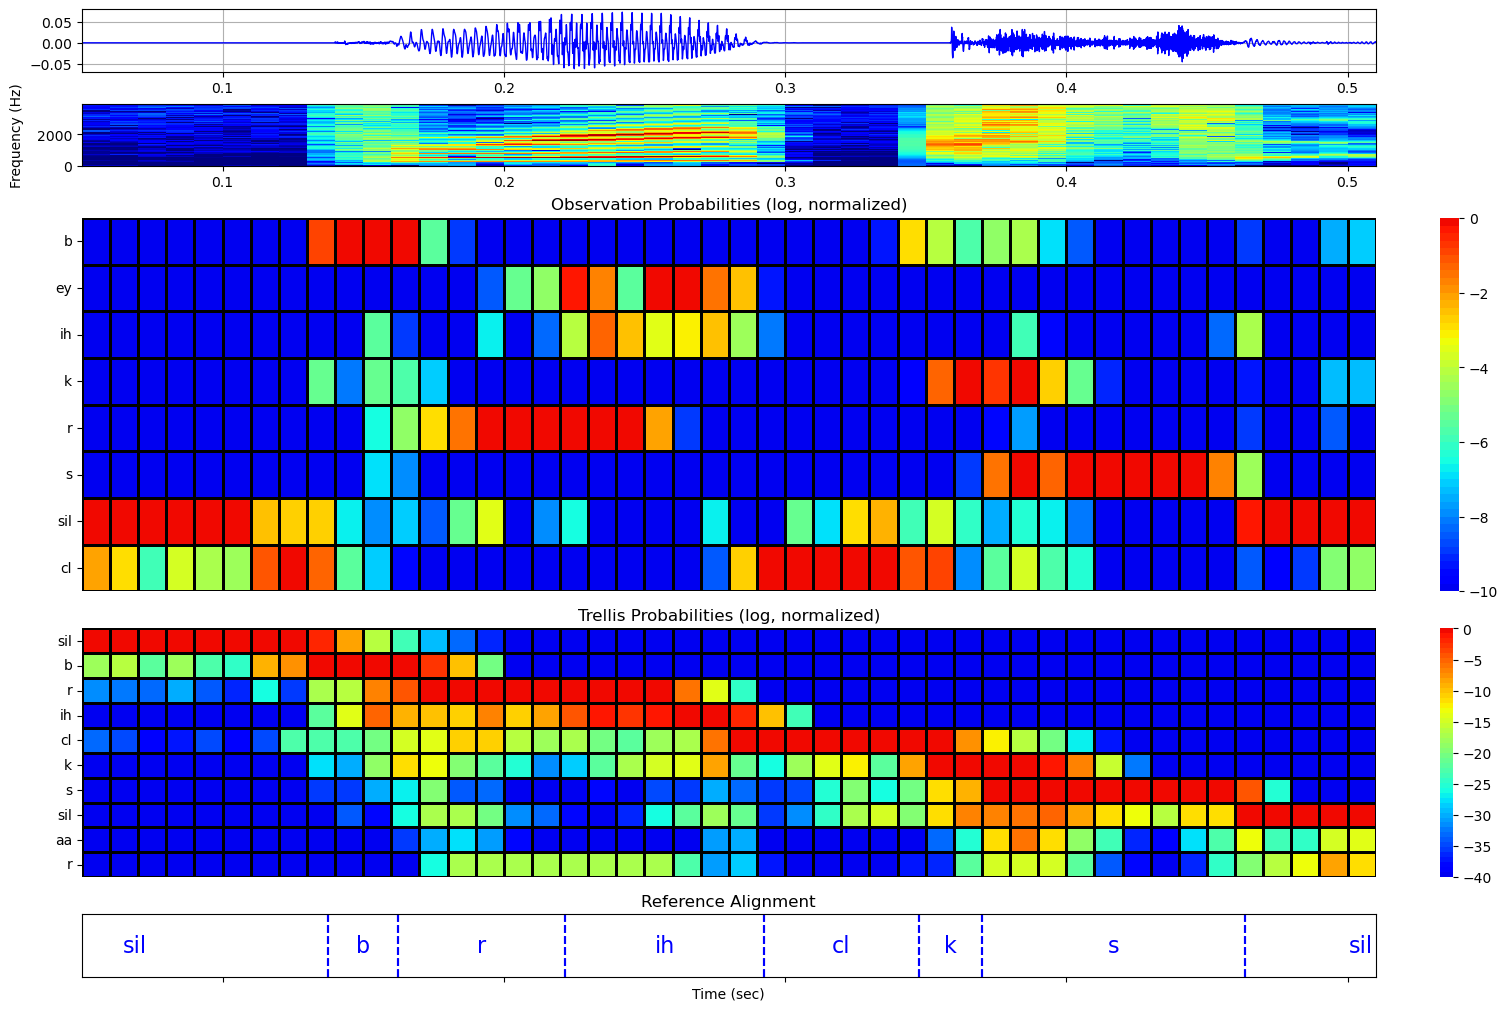

Agreement with manual alignment: 79.56 %


In [235]:
transcript_sel = np.array(transcript)[state_sel]
obs_probs_raw = clf_GMM.predict_log_prob(X)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(X)
# recognize from the trellis
y_vit_lbl = hmm2.states[trellis2.backtrace()]
y_vit_seg = Spch.lbls2seg(y_vit_lbl)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata[0:128,:],dy=4000/128,frames=frames,sample_rate=sr,figsize=(15,10),row_heights=[1,1,6,4,1],
                  img_ftrs=[None,None,None])
# plot normalized observation probabilities
obs_probs = obs_probs_raw-np.max(obs_probs_raw,axis=1,keepdims=True)
tr_probs = trellis2.probs
plot_probs(obs_probs[frame_sel,indx_sel],fig=fig,iax=2,labels=phn_sel,style="img",vmin=-10.,title="Observation Probabilities (log, normalized)")
plot_probs(tr_probs[frame_sel,state_sel],fig=fig,labels=transcript_sel,iax=3,style="img",vmin=-40.,title="Trellis Probabilities (log, normalized)")
#fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

#fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')
fig.add_seg_plot(seg_phn,iax=4,ypos=0.5,color='b',title='Reference Alignment')
display(fig)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Agreement with manual alignment: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

In [137]:
pd.set_option('display.float_format', '{:.2f}'.format)
i1 = 95
i2 = 101
dfo1 = pd.DataFrame(obs_probs[i1:i2,indx_sel].T,index=phn_sel,columns=np.arange(i1,i2))
dft1 = pd.DataFrame(tr_probs[i1:i2,state_sel].T,index=transcript_sel,columns=np.arange(i1,i2))

In [16]:
dfo1

,95,96,97,98,99,100
ah,-4.35,-3.35,-1.67,-1.27,-5.04,-7.80
eh,-2.80,0.00,-0.45,-5.88,-15.42,-21.97
m,-1.42,-3.21,-4.87,-3.27,-7.63,-9.39
g,-11.94,-8.50,-9.19,-7.63,-8.15,-7.86
ih,-3.36,-4.25,0.00,-2.66,-11.71,-14.54
k,-9.39,-9.38,-6.53,-5.12,-5.44,-4.75
p,-13.94,-12.16,-9.77,-6.57,-3.30,-2.16
r,-7.14,-5.97,-6.50,-8.31,-15.13,-19.07
s,-19.08,-16.08,-4.15,-1.14,-3.24,-3.09
t,-5.65,-3.30,-5.52,-2.96,-2.72,-2.01


In [17]:
dft1

,95,96,97,98,99,100
k,-91.68,-89.60,-84.32,-84.09,-84.83,-84.21
ah,-86.64,-83.57,-79.46,-79.59,-84.15,-87.26
m,-84.51,-87.72,-88.00,-81.60,-86.74,-93.13
p,-97.03,-96.67,-92.90,-84.90,-82.41,-84.16
y,-99.67,-93.34,-95.73,-96.84,-92.16,-93.13
uw,-66.79,-71.63,-77.34,-82.21,-94.61,-96.07
t,-14.11,-17.41,-22.48,-24.31,-26.54,-28.14
eh,0.00,0.00,0.00,-4.75,-19.68,-41.24
r,-4.34,-5.97,-6.05,-7.18,-19.40,-38.06
s,-16.29,-16.08,-3.70,0.00,-2.76,-5.44


In [ ]:
phn_sel

In [ ]:
obs_probs.shape,tr_probs[-30:,-5:]

In [ ]:
ph2indx